# Problem Statement

Build a predictive model to categorize news text into 20 predefined news topics.

# About the data

I worked with the 20 Newsgroups Text Dataset. This dataset is described as being composed of 18000 newsgroup posts categorized into 20 different topics and split into 2 subsets: one for training and one for testing (based on date posted). Information about the dataset can be found [here](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset). However, sklearn does not appear to provide any description of the data from its original creator. They do provide [this website](http://qwone.com/~jason/20Newsgroups/), but it is not an original description (as admitted on the site). From my own exploration, the data did not appear to be "news" so much as short blurbs from a discussion forum.

# Exploratory Data Analysis

I familiarized myself with the categories that the dataset was sorted into, the format of the news posts, the size and shape of the dataset, and the number of samples organized into each category.

In [1]:
from sklearn.datasets import fetch_20newsgroups

# data already comes split into train and test groups

news_train = fetch_20newsgroups(
    subset = "train",
    remove = ('headers', 'footers') # remove unnecessary information from data
)

news_train.target_names # lists the 20 topics that the newsgroup posts could be organized into

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [2]:
import pandas as pd

# turn the data into pandas data frames for easier visualization
# includes the post (under "News Text") and the category that the post is organized into (under "Category")

train_df = pd.DataFrame()
train_df["News Text"] = news_train.data
train_df["Category"] = [news_train.target_names[x] for x in news_train.target]

In [3]:
train_df.head(10)

News Text                  Category
0  I was wondering if anyone out there could enli...                 rec.autos
1  A fair number of brave souls who upgraded thei...     comp.sys.mac.hardware
2  well folks, my mac plus finally gave up the gh...     comp.sys.mac.hardware
3  Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...             comp.graphics
4  From article <C5owCB.n3p@world.std.com>, by to...                 sci.space
5  In article <1r1eu1$4t@transfer.stratus.com> cd...        talk.politics.guns
6  There were a few people who responded to my re...                   sci.med
7  DXB132@psuvm.psu.edu writes:\n>In article <1ql...  comp.sys.ibm.pc.hardware
8  I have win 3.0 and downloaded several icons an...   comp.os.ms-windows.misc
9  jap10@po.CWRU.Edu (Joseph A. Pellettiere) writ...     comp.sys.mac.hardware

In [4]:
train_df.values.shape # the training data is 11314 rows = 11314 categorized posts

(11314, 2)

In [5]:
train_df["Category"].value_counts() # categories have a pretty good balance of data in each

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: Category, dtype: int64

# Data Preprocessing

I removed all the posts that had nothing in them because there was no other data for me to work with in those cases. I believe that these samples must have been made entirely of headers and/or footers and were thus left blank when I removed headers and footers. I feel that their inclusion in the dataset is not necessary and may, in fact, confuse the model due to them being blank and having no data to sort by.

I also removed duplicates because I saw no reason to keep them. I left in 1 of each of the duplicates such that all rows were unique afterwards. Again, these duplicates may have been the result of removing headers and footers from the dataset.

Originally, I did not include lemmatization in my preprocessing, but the dataset proved to be too large, even after feature reduction, so I included it in order to shrink the number of features I was working with. Lemmatization is a type of data normalization in natural language processing (NLP) in which words are reduced to their base/dictionary form, or lemma. For example, "play", "played", and "playing" would all be considered the same word after lemmatization.

I performed all of the same preprocessing steps to the testing data that I did to the training data because it needed to undergo the same cleaning and manipulation for classification as the training data. It would have been convenient to be able to use something similar to sklearn's pipeline class to accomplish this, but I am not sure if such a thing exists.

### Missing Values

In [6]:
[train_df["News Text"].isnull().sum(), # how many posts are null = 0
train_df["News Text"].isna().sum(), # how many posts are NA = 0
train_df["News Text"].str.isspace().sum(), # how many posts are whitespace = 15
train_df["News Text"].eq("").sum()] # how many posts are a string of nothing = 3

[0, 0, 15, 3]

In [7]:
# remove samples with no data
train_df = train_df[
    ~ train_df["News Text"].isnull() &
    ~ train_df["News Text"].isna() &
    ~ train_df["News Text"].str.isspace() &
    ~ train_df["News Text"].eq("")
]
train_df.shape # those blank posts have been removed

(11296, 2)

### Duplicate Values

In [8]:
train_df.duplicated().sum() # 26 posts are duplicates of 26 other posts (26 posts should be removed)

26

In [9]:
train_df = train_df[~ train_df.duplicated()] # filter out duplicates
train_df.shape

(11270, 2)

In [10]:
train_df = train_df.reset_index(drop=True)
train_df["Category"].value_counts() # still looks relatively well balanced

soc.religion.christian      599
rec.sport.hockey            599
rec.sport.baseball          596
sci.crypt                   595
rec.motorcycles             595
sci.med                     594
sci.space                   592
rec.autos                   591
sci.electronics             590
comp.sys.ibm.pc.hardware    587
comp.os.ms-windows.misc     586
comp.windows.x              582
comp.graphics               582
misc.forsale                577
comp.sys.mac.hardware       575
talk.politics.mideast       563
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          376
Name: Category, dtype: int64

### Lemmatization

In [11]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    disable=["parser", "ner"]
)

def lemmatizer(text):
  doc = nlp(text)
  lem_list = [token.lemma_ for token in doc]
  return " ".join(lem_list)

train_df["Lemmatized Text"] = train_df["News Text"].apply(lemmatizer) # really long runtime, not sure how to vectorize this?
train_df.head()

News Text               Category  \
0  I was wondering if anyone out there could enli...              rec.autos   
1  A fair number of brave souls who upgraded thei...  comp.sys.mac.hardware   
2  well folks, my mac plus finally gave up the gh...  comp.sys.mac.hardware   
3  Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...          comp.graphics   
4  From article <C5owCB.n3p@world.std.com>, by to...              sci.space   

                                     Lemmatized Text  
0  I be wonder if anyone out there could enlighte...  
1  a fair number of brave soul who upgrade their ...  
2  well folk , my mac plus finally give up the gh...  
3  Robert J.C. Kyanko ( rob@rjck . UUCP ) write :...  
4  from article < c5owcb.n3p@world.std.com > , by...

### Preprocessing Testing Data

In [12]:
# I will need to apply the same preprocessing steps to the testing data as the training data
# it has to be preprocessed separately to prevent data leakage
# it would be convenient to be able to do this using sklearn pipeline or something similar
# however, I believe some of the steps that I perform cannot be implemented in pipeline

news_test = fetch_20newsgroups(
    subset = "test",
    remove = ('headers', 'footers') # remove unnecessary information from data
)

# store data in a pandas dataframe
test_df = pd.DataFrame()
test_df["News Text"] = news_test.data
test_df["Category"] = [news_test.target_names[x] for x in news_test.target]

# remove samples with empty values
test_df = test_df[
    ~ test_df["News Text"].isnull() &
    ~ test_df["News Text"].isna() &
    ~ test_df["News Text"].str.isspace() &
    ~ test_df["News Text"].eq("")
]

# remove duplicate samples
test_df = test_df[~ test_df.duplicated()]

# reindex the dataframe
test_df = test_df.reset_index(drop=True)

# lemmatize the data
test_df["Lemmatized Text"] = test_df["News Text"].apply(lemmatizer) # again, long runtime

# Data Visualization

First I made a pie chart to show what percentage of the total dataset is comprised of each category. The pie chart shows that the categories are relatively well balanced.

Then, since the data is entirely made of words, it made sense to visualize it with word clouds. I chose to create a separate word cloud for each category. To do this, I grouped all of the (lemmatized) posts from each category, then used the wordcloud library to create an image that included words used in those posts sized proportionally to their frequency. For example, posts categorized under alt.atheism frequently mention the words "God," "one," "write," "say," and "people."

From these word clouds, I was able to see which words are most prevalent in each category and discern that most are relatively different. On the other hand, I also saw that "write" and "-" were present in almost every word cloud. This suggests that these words/features will not be very instrumental in sorting through the data.

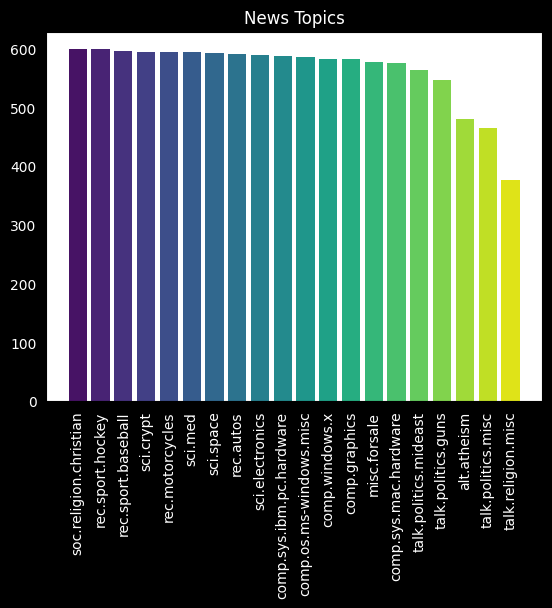

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(
    facecolor="black"
)

plt.bar(
    x=train_df['Category'].value_counts().keys(),
    height=train_df['Category'].value_counts().values,
    color=sns.color_palette("viridis", 20),
    label=train_df['Category'].value_counts().keys()
)
plt.xticks(
    rotation=90,
    color="white"
)
plt.yticks(
    color="white"
)
plt.title(
    "News Topics",
    color="white"
)
plt.show()

In [14]:
from wordcloud import WordCloud

def cloud(dataframe, category):
  tempdf = dataframe[(dataframe.Category == category)] # filter pandas data frame based on category
  text = " ".join(tempdf["Lemmatized Text"].tolist()) # create one long String from joining all the posts in the selected category
  wc = WordCloud(
      collocations = False,
      width = 300,
      height = 300
  )
  wc.generate(text) # feed the resulting string into the word cloud generator
  plt.axis("off")
  plt.imshow(
      wc,
      interpolation = "bilinear"
  )
  plt.show() # show the created word cloud

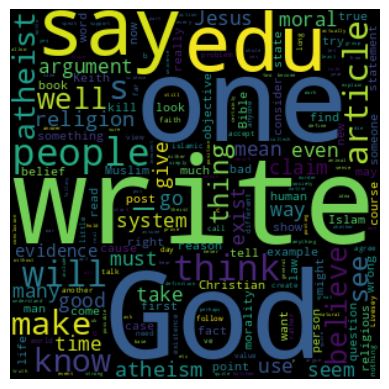

In [15]:
cloud(train_df, "alt.atheism")

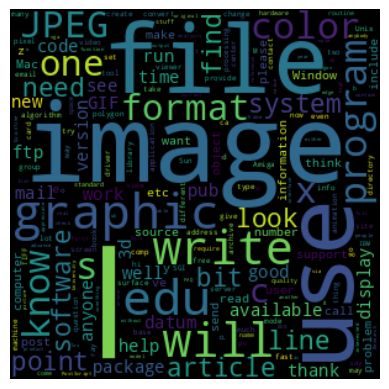

In [16]:
cloud(train_df, "comp.graphics")

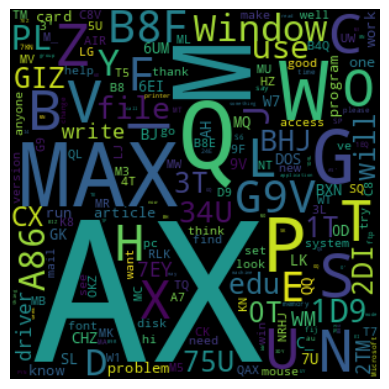

In [17]:
cloud(train_df, "comp.os.ms-windows.misc")

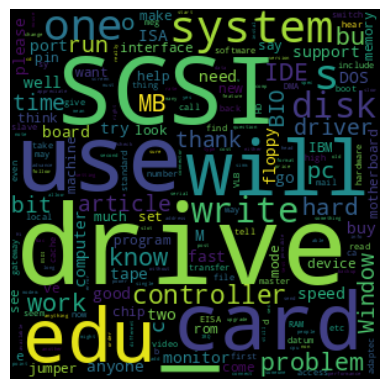

In [18]:
cloud(train_df, "comp.sys.ibm.pc.hardware")

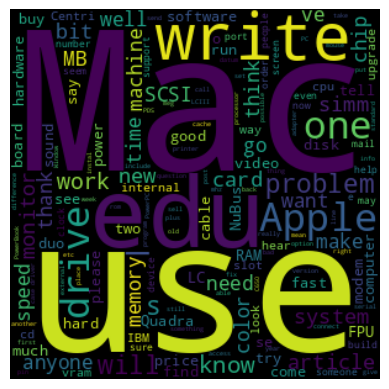

In [19]:
cloud(train_df, "comp.sys.mac.hardware")

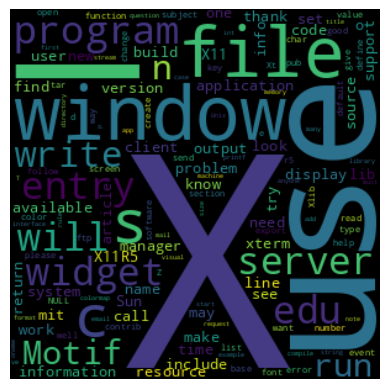

In [20]:
cloud(train_df, "comp.windows.x")

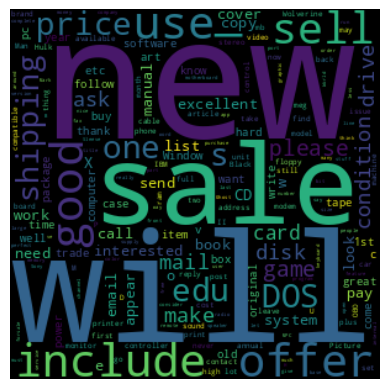

In [21]:
cloud(train_df, "misc.forsale")

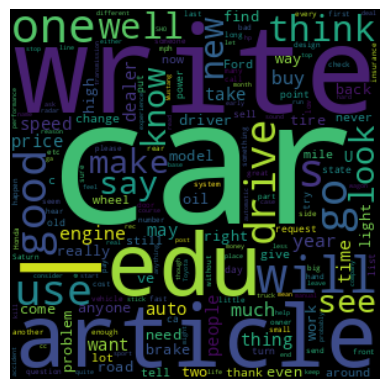

In [22]:
cloud(train_df, "rec.autos")

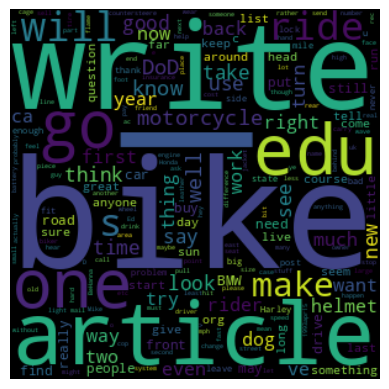

In [23]:
cloud(train_df, "rec.motorcycles")

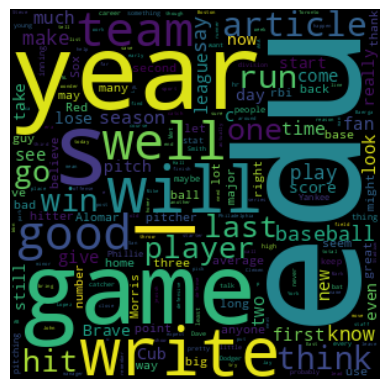

In [24]:
cloud(train_df, "rec.sport.baseball")

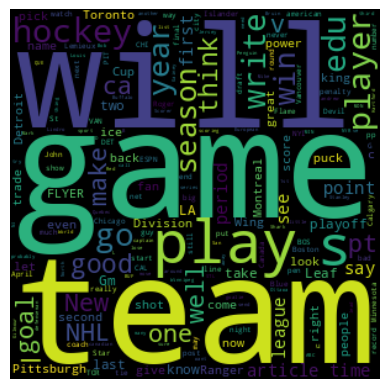

In [25]:
cloud(train_df, "rec.sport.hockey")

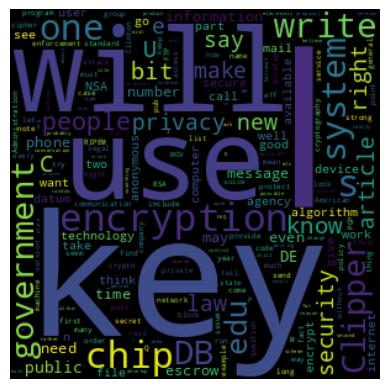

In [26]:
cloud(train_df, "sci.crypt")

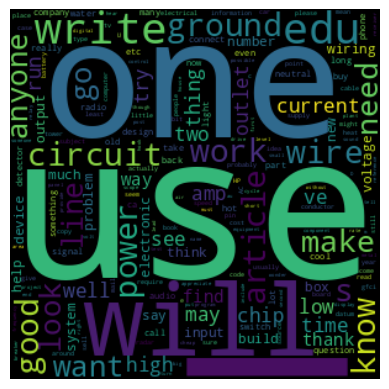

In [27]:
cloud(train_df, "sci.electronics")

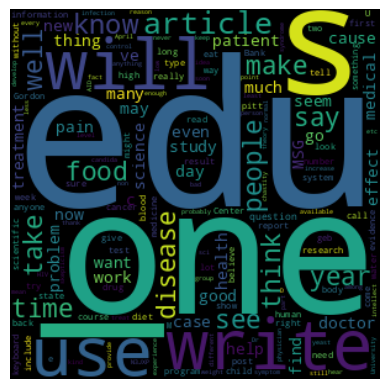

In [28]:
cloud(train_df, "sci.med")

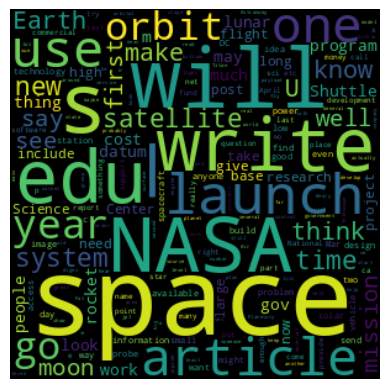

In [29]:
cloud(train_df, "sci.space")

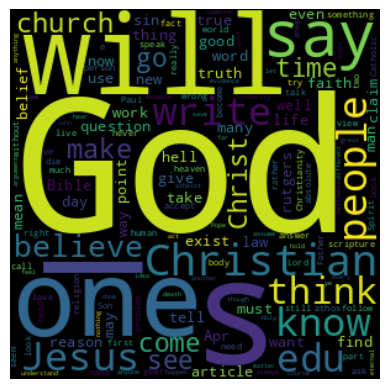

In [30]:
cloud(train_df, "soc.religion.christian")

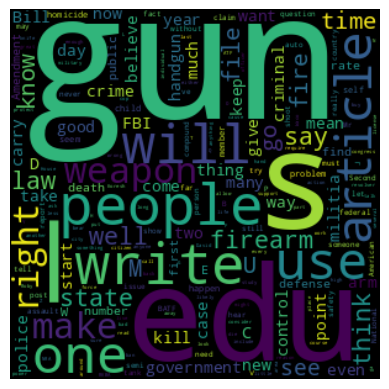

In [31]:
cloud(train_df, "talk.politics.guns")

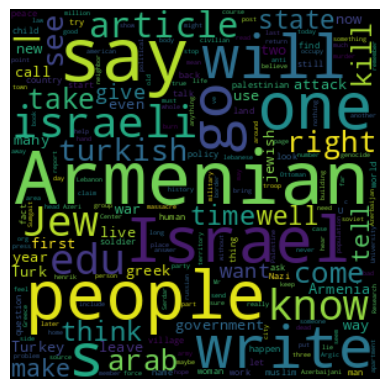

In [32]:
cloud(train_df, "talk.politics.mideast")

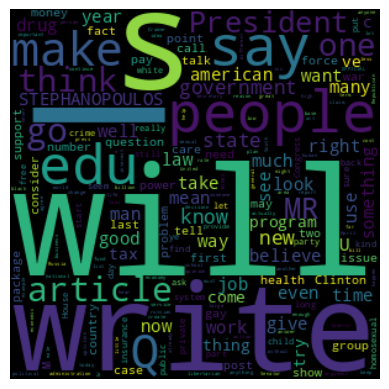

In [33]:
cloud(train_df, "talk.politics.misc")

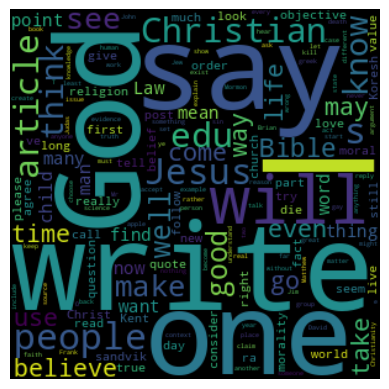

In [34]:
cloud(train_df, "talk.religion.misc")

# Feature Engineering

I opted to use TF-IDF (Term Frequency - Inverse Document Frequency) to create numerical features from the raw textual data. Essentially, every word that appeared in the training dataset became a feature (105,683 unique words in the lemmatized training dataset). For each post, the value of each feature (word) was calculated using the frequency of that word in the post and its frequency in the dataset as a whole. The 20 newsgroups text dataset actually comes with an option to work with the data after having already been vectorized using TF-IDF, but for the assignment, I decided to implement this technique myself. After fitting the model on the training data, I transformed the testing data with the resulting document-term matrix. This gave the testing data the same form and features as the training data so that it could be analyzed using the models that were trained on the training data.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(
    stop_words="english" # remove words such as "the," "a," "an," etc. Not strictly necessary in TF-IDF but resulted in less features to add to my data frame
)

tfidf_features = v.fit_transform(train_df["Lemmatized Text"].to_numpy()) # returns a sparse matrix of the features corresponding to each post
tfidf_features_df = pd.DataFrame.sparse.from_spmatrix(tfidf_features) # converting the sparse matrix to a pandas data frame
tfidf_features_df.columns = v.get_feature_names_out() # adding the words that correspond to the features as the column names in the data frame

# put together each post, its category, and its calculated features into one data frame
train_tfidf_df = train_df.join(tfidf_features_df)

In [36]:
train_tfidf_df.head()

News Text               Category  \
0  I was wondering if anyone out there could enli...              rec.autos   
1  A fair number of brave souls who upgraded thei...  comp.sys.mac.hardware   
2  well folks, my mac plus finally gave up the gh...  comp.sys.mac.hardware   
3  Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...          comp.graphics   
4  From article <C5owCB.n3p@world.std.com>, by to...              sci.space   

                                     Lemmatized Text   00  000  0000  00000  \
0  I be wonder if anyone out there could enlighte...  0.0  0.0   0.0    0.0   
1  a fair number of brave soul who upgrade their ...  0.0  0.0   0.0    0.0   
2  well folk , my mac plus finally give up the gh...  0.0  0.0   0.0    0.0   
3  Robert J.C. Kyanko ( rob@rjck . UUCP ) write :...  0.0  0.0   0.0    0.0   
4  from article < c5owcb.n3p@world.std.com > , by...  0.0  0.0   0.0    0.0   

   000000  00000000  0000000004  ...  zzrk  zztop  zzy_3w  zzz  zzzoh  zzzzzz  \
0     0.0       0.0         0.0  ...   0.0    0.0     0.0  0.0    0.0     0.0   
1     0.0       0.0         0.0  ...   0.0    0.0     0.0  0.0    0.0     0.0   
2     0.0       0.0         0.0  ...   0.0    0.0     0.0  0.0    0.0     0.0   
3     0.0       0.0         0.0  ...   0.0    0.0     0.0  0.0    0.0     0.0   
4     0.0       0.0         0.0  ...   0.0    0.0     0.0  0.0    0.0     0.0   

   zzzzzzt  ³ation  ñaustin   ýé  
0      0.0     0.0      0.0  0.0  
1      0.0     0.0      0.0  0.0  
2      0.0     0.0      0.0  0.0  
3      0.0     0.0      0.0  0.0  
4      0.0     0.0      0.0  0.0  

[5 rows x 105686 columns]

In [37]:
# the testing data needs to be fitted to the categories created by using TF-IDF on the training data
test_tfidf_values = v.transform(test_df["Lemmatized Text"].to_numpy())

# Feature Reduction

According to the [sklearn documentation for PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), the PCA class does not support sparse input, which is what I was working with. Therefore, I performed feature reduction by way of [truncated Singular Value Decomposition (SVD)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) - aka Latent Semantic Analysis (LSA).

Contrary to PCA, truncated SVD does not need data to be normalized beforehand, which is why it works well for sparse matrices. Centering the data would cause memory usage to explode. However, because the data has not been centered, the explained variance ratios are not listed in descending order. Therefore, for the 100 component reduction, I have visualized the retained information using singular values, instead of explained variance ratios. It is worth noting that similar bar plots made for the 1000 and 3000 component reductions would start with the exact same information as that of the 100 component reduction. They would have additional descending bars as part of their charts up to 1000 and 3000 respectively.

After performing TF-IDF on the lemmatized news texts, the dataset was comprised of 105,683 features (dimensions). Here, I performed truncated SVD thrice, using different values for n_components. This variable refers to the number of features that the dataset was reduced (projected) to. First I tried reducing the the dataset to 100 components, then to 1000 components, then to 3000 components (the last of which had quite a long runtime).

I also calculated the total variance that was captured in each of these reductions. A projection to 100 dimensions from the original dataset effectively communicated ~12% of the variance in the data. A projection to 1000 dimensions effectively communicated ~46% of the variance in the data. A projection of 3000 dimensions effectively communicated ~74% of the variance in the data. I would have liked to project to an even higher number of features, but the runtime to project to 3000 features was already very long and projecting to 5000 required too much RAM to be able to run in Google Colab. Furthermore, some of the models (specifically the decision tree with tuned hyperparameters) already had difficulty working with the 3000 component projection and also had incredibly long runtimes.

In [38]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(
    n_components=100, # accounts for ~12% of variance
    random_state=42
)

svd_features = svd.fit_transform(tfidf_features)
svd.explained_variance_ratio_.sum()

0.11977260450221619

Text(0.5, 0, 'Singular Values')

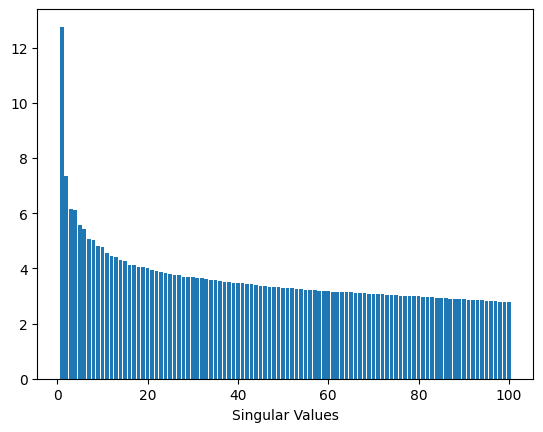

In [39]:
plt.bar(
    x=range(1, 101),
    height=svd.singular_values_
)
plt.xlabel("Singular Values")

In [40]:
svd1000 = TruncatedSVD(
    n_components=1000, # accounts for ~46% of variance
    random_state=42
)

svd1000_features = svd1000.fit_transform(tfidf_features)
svd1000.explained_variance_ratio_.sum()

0.45937775549741533

In [41]:
svd3000 = TruncatedSVD(
    n_components=3000, # accounts for ~74% of variance; unable to run with n_components=5000
    random_state=42
)

svd3000_features = svd3000.fit_transform(tfidf_features) # very long runtime
svd3000.explained_variance_ratio_.sum()


0.7422179732732466

In [42]:
svd_features_df = pd.DataFrame(svd_features)
train_svd_features_df = train_df.join(svd_features_df)

In [43]:
train_svd_features_df.head()

News Text               Category  \
0  I was wondering if anyone out there could enli...              rec.autos   
1  A fair number of brave souls who upgraded thei...  comp.sys.mac.hardware   
2  well folks, my mac plus finally gave up the gh...  comp.sys.mac.hardware   
3  Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...          comp.graphics   
4  From article <C5owCB.n3p@world.std.com>, by to...              sci.space   

                                     Lemmatized Text         0         1  \
0  I be wonder if anyone out there could enlighte...  0.125132  0.019946   
1  a fair number of brave soul who upgrade their ...  0.098467  0.094081   
2  well folk , my mac plus finally give up the gh...  0.199633  0.074571   
3  Robert J.C. Kyanko ( rob@rjck . UUCP ) write :...  0.125819  0.025209   
4  from article < c5owcb.n3p@world.std.com > , by...  0.151840  0.012449   

          2         3         4         5         6  ...        90        91  \
0  0.073276 -0.023847  0.081515 -0.058726  0.030576  ... -0.030241 -0.023018   
1 -0.025880 -0.030252  0.063531  0.028588 -0.013423  ...  0.022848  0.027835   
2  0.003872 -0.030181 -0.002668  0.008284 -0.009998  ...  0.004508 -0.003393   
3  0.022391  0.054547 -0.013182  0.001604  0.090967  ... -0.033548 -0.023106   
4  0.001276 -0.018765 -0.016846 -0.046271  0.071798  ... -0.003186 -0.044232   

         92        93        94        95        96        97        98  \
0 -0.016397  0.001315 -0.022957  0.032862  0.010020 -0.000341 -0.008871   
1 -0.021106  0.055836  0.044093  0.004365 -0.012211 -0.001039 -0.018459   
2  0.034494 -0.006235 -0.022842 -0.014824  0.013973 -0.006241  0.014718   
3  0.019259 -0.030379  0.007678  0.004014  0.003280 -0.001796  0.023291   
4 -0.000020  0.015258  0.006895 -0.033468  0.011437  0.039692  0.008705   

         99  
0 -0.001719  
1  0.018908  
2 -0.013816  
3  0.002948  
4  0.010406  

[5 rows x 103 columns]

In [44]:
# as with preprocessing, I need the testing data to be in the same format as the training data
# here, I reduce the features in the test data to the same features that the training data was fitted to
test_svd_feature_values = svd.transform(test_tfidf_values)

test_svd3000_feature_values = svd3000.transform(test_tfidf_values)

# Models

I trained several models on the data, selected for their ability to classify data:

*   4 multinomial logistic regression models optimized with gradient descent and having different values of alpha and using different regularization techniques
*   an RBF support vector machine using a one-versus-rest decision function (good for large datasets like mine)
*   a decision tree
*   a decision tree with tuned hyperparameters
*   a random forest

I also created my own implementation of stochastic gradient descent. However, it required too much RAM to run properly in Google Colab, so I am unsure if it actually works properly and I cannot include it in my analysis.

Because the models struggled so much with the 3000 component dataset, I decided to compare them using the 100 component dataset. Because I was not focused on any particularly category, I primarily analyzed the performance of each model via their accuracies. However, I also calculated their precisions, recalls, and F1 scores, along with a confusion matrix. After determining which method worked best for the smaller 100 component dataset, I applied it to the 3000 component dataset and analyzed its performance. In this case, SVM performed the best for the 100 component dataset, so I used SVM on the 3000 component dataset as well.

In [47]:
metrics_before_reduction = pd.DataFrame()
metrics_before_reduction.index = ["Accuracy", "Precision", "Recall", "F1 score"]

## Evaluation Function

In [45]:
from sklearn import metrics
import seaborn as sns

def evaluate(true, predicted, classes, model_name):
  print(metrics.classification_report(true, predicted, target_names=classes, zero_division=0.0))

  accuracy = metrics.accuracy_score(true, predicted)
  precision = metrics.precision_score(true, predicted, average="macro", zero_division=0.0)
  recall = metrics.recall_score(true, predicted, average="macro")
  f1score = metrics.f1_score(true, predicted, average="macro")

  cf_matrix = metrics.confusion_matrix(
      true,
      predicted,
      labels=classes
  )
  ax = sns.heatmap(
      cf_matrix,
      cmap="viridis",
      xticklabels=classes,
      yticklabels=classes
  )
  ax.set_xlabel("Predicted")
  ax.set_ylabel("True")
  ax.set_title(model_name)
  plt.show()

  return [accuracy, precision, recall, f1score]

## Manually Implemented Gradient Descent

My implementation of stochastic gradient descent required too much RAM for Google Colab to handle. I leave the code here for viewing in the hopes that I might get partial credit for its presence, but I am unable to verify that it works nor include it in my analysis. I have commented out the offending code to allow for the entire notebook to be run at once without crashing.

In [46]:
from sklearn.preprocessing import OneHotEncoder

def score(a, b):
  return a @ b

def softmax(x):
  return np.exp(x) / np.sum(np.exp(x))

def sgd(a, b):
  return np.outer(a, b)

def fit_gradient_descent(X, y, learning_rate, iterations):
  enc = OneHotEncoder(handle_unknown="ignore")
  Y = enc.fit(y)

  n = X.shape[0]

  X_matrix = np.c_[np.ones((n, 1)), X]
  weights = np.random.randn(X_matrix.shape[1], enc.n_features_in_.shape[1])

  for i in range(iterations):
    prm = np.random.permutation(n)

    for j in prm:
      softmax_score = softmax(score(weights, X_matrix[j]))
      gradients = sgd(softmax_score - Y[j], X_matrix[j])
      weights -= learning_rate * gradients

  return weights, enc.categories_[0]

def predict_gradient_descent(X, weights, categories):
  predictions = []

  n = X.shape[0]

  X_matrix = np.c_[np.ones(n, 1), X]

  for i in range(n):
    softmax_score = softmax(score(weights, X_matrix[i]))
    prediction_index = np.argmax(softmax_score)
    predictions.append(categories[prediction_index])

  return predictions

In [ ]:
import numpy as np

#weights, categories = fit_gradient_descent(tfidf_features_df, np.array(train_df["Category"]).reshape(1, -1), 0.1, 10)

In [ ]:
#metrics_before_reduction["Manual SGD"] = evaluate(test_df["Category"], predict_gradient_descent(test_tfidf_values, weights, categories), news_train.target_names, "Manual SGD")

## Before Feature Reduction

### Multinomial Logistic Regression Using Gradient Descent

#### Alpha: 0.001, Regularization: L1

In [48]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(
    loss="log_loss",
    penalty="l1",
    alpha=0.001,
    learning_rate="optimal",
    random_state=42
).fit(tfidf_features, train_df["Category"])

##### Performance Metrics

                          precision    recall  f1-score   support

             alt.atheism       0.00      0.00      0.00       318
           comp.graphics       0.63      0.35      0.45       389
 comp.os.ms-windows.misc       0.44      0.53      0.48       391
comp.sys.ibm.pc.hardware       0.36      0.37      0.36       391
   comp.sys.mac.hardware       0.58      0.44      0.50       383
          comp.windows.x       0.59      0.44      0.50       389
            misc.forsale       0.19      0.65      0.29       378
               rec.autos       0.75      0.56      0.64       396
         rec.motorcycles       0.95      0.44      0.60       398
      rec.sport.baseball       0.13      0.22      0.16       397
        rec.sport.hockey       0.49      0.82      0.62       399
               sci.crypt       0.70      0.65      0.67       396
         sci.electronics       0.10      0.18      0.13       393
                 sci.med       0.36      0.30      0.33       393
         

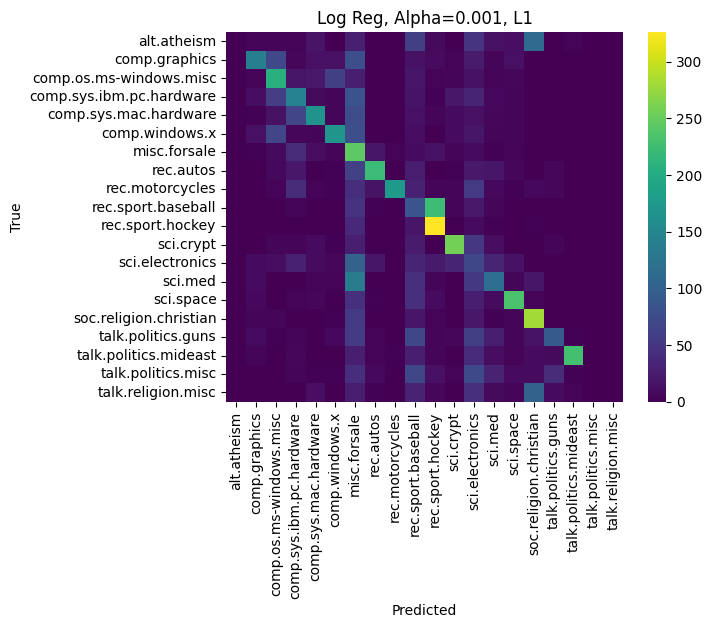

In [49]:
metrics_before_reduction["Log Reg, Alpha=0.001, L1"] = evaluate(test_df["Category"], clf.predict(test_tfidf_values), news_train.target_names, "Log Reg, Alpha=0.001, L1")

#### Alpha: 0.001, Regularization: L2

In [50]:
clf = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=0.001,
    learning_rate="optimal",
    random_state=42
).fit(tfidf_features, train_df["Category"])

##### Performance Metrics

                          precision    recall  f1-score   support

             alt.atheism       0.77      0.46      0.58       318
           comp.graphics       0.68      0.72      0.70       389
 comp.os.ms-windows.misc       0.66      0.72      0.69       391
comp.sys.ibm.pc.hardware       0.62      0.69      0.65       391
   comp.sys.mac.hardware       0.75      0.68      0.72       383
          comp.windows.x       0.81      0.72      0.76       389
            misc.forsale       0.70      0.76      0.73       378
               rec.autos       0.87      0.83      0.85       396
         rec.motorcycles       0.79      0.88      0.83       398
      rec.sport.baseball       0.85      0.84      0.85       397
        rec.sport.hockey       0.85      0.97      0.91       399
               sci.crypt       0.86      0.84      0.85       396
         sci.electronics       0.70      0.61      0.65       393
                 sci.med       0.75      0.86      0.80       393
         

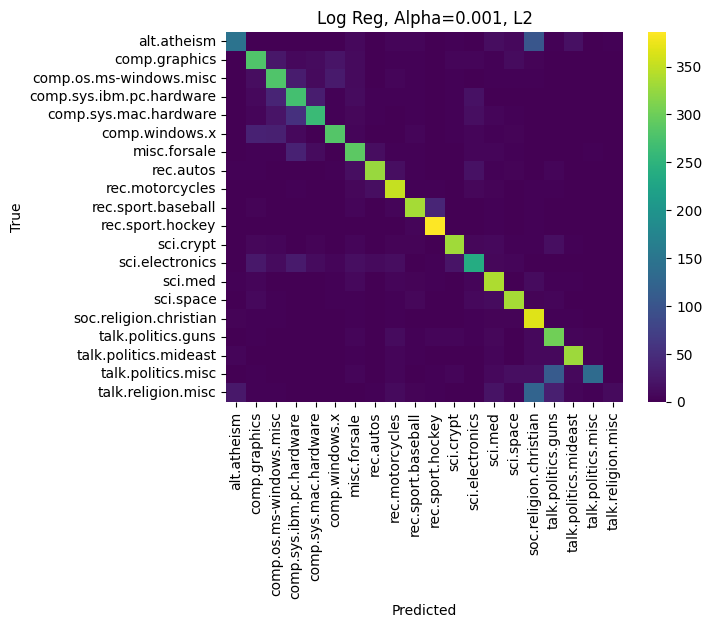

In [51]:
metrics_before_reduction["Log Reg, Alpha=0.001, L2"] = evaluate(test_df["Category"], clf.predict(test_tfidf_values), news_train.target_names, "Log Reg, Alpha=0.001, L2")

#### Alpha: 0.1, Regularization: L1

In [52]:
clf = SGDClassifier(
    loss="log_loss",
    penalty="l1",
    alpha=0.1,
    learning_rate="optimal",
    random_state=42
).fit(tfidf_features, train_df["Category"])

##### Performance Metrics

                          precision    recall  f1-score   support

             alt.atheism       0.00      0.00      0.00       318
           comp.graphics       0.00      0.00      0.00       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       391
comp.sys.ibm.pc.hardware       0.00      0.00      0.00       391
   comp.sys.mac.hardware       0.00      0.00      0.00       383
          comp.windows.x       0.00      0.00      0.00       389
            misc.forsale       0.00      0.00      0.00       378
               rec.autos       0.00      0.00      0.00       396
         rec.motorcycles       0.00      0.00      0.00       398
      rec.sport.baseball       0.05      1.00      0.10       397
        rec.sport.hockey       0.00      0.00      0.00       399
               sci.crypt       0.00      0.00      0.00       396
         sci.electronics       0.00      0.00      0.00       393
                 sci.med       0.00      0.00      0.00       393
         

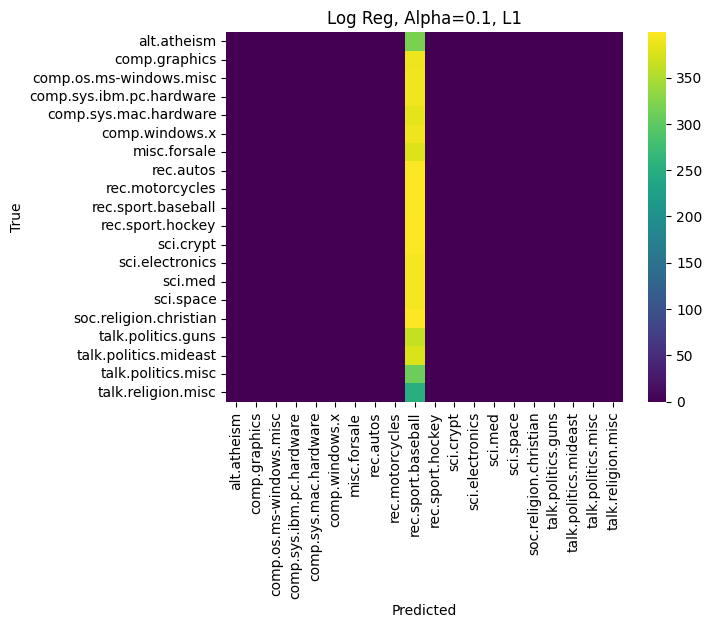

In [53]:
metrics_before_reduction["Log Reg, Alpha=0.1, L1"] = evaluate(test_df["Category"], clf.predict(test_tfidf_values), news_train.target_names, "Log Reg, Alpha=0.1, L1")

#### Alpha: 0.1, Regularization: L2

In [54]:
clf = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=0.1,
    learning_rate="optimal",
    random_state=42
).fit(tfidf_features, train_df["Category"])

##### Performance Metrics

                          precision    recall  f1-score   support

             alt.atheism       0.00      0.00      0.00       318
           comp.graphics       0.96      0.06      0.11       389
 comp.os.ms-windows.misc       0.75      0.28      0.41       391
comp.sys.ibm.pc.hardware       0.18      0.95      0.30       391
   comp.sys.mac.hardware       0.00      0.00      0.00       383
          comp.windows.x       0.97      0.09      0.16       389
            misc.forsale       0.90      0.24      0.38       378
               rec.autos       0.88      0.39      0.54       396
         rec.motorcycles       1.00      0.20      0.33       398
      rec.sport.baseball       0.17      0.98      0.28       397
        rec.sport.hockey       1.00      0.08      0.15       399
               sci.crypt       0.95      0.46      0.62       396
         sci.electronics       1.00      0.00      0.01       393
                 sci.med       1.00      0.01      0.02       393
         

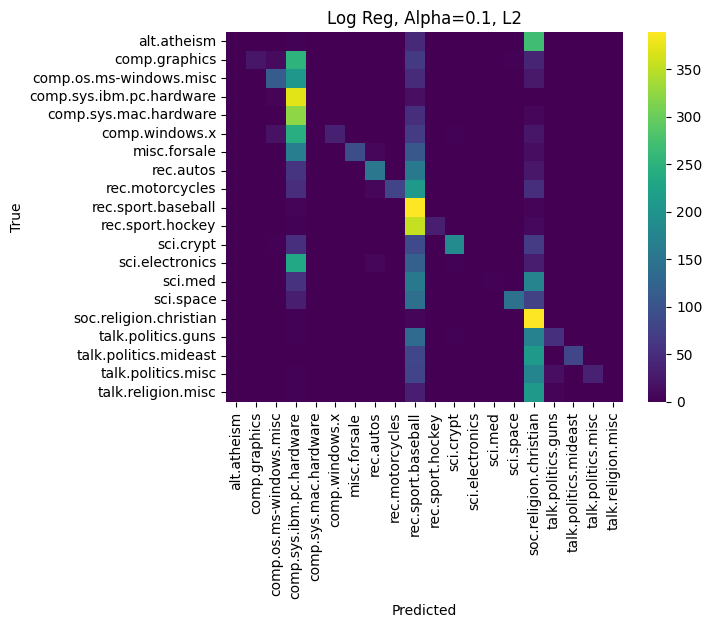

In [55]:
metrics_before_reduction["Log Reg, Alpha=0.1, L2"] = evaluate(test_df["Category"], clf.predict(test_tfidf_values), news_train.target_names, "Log Reg, Alpha=0.1, L2")

### Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(tfidf_features, train_df["Category"])
clf.get_depth()

380

#### Performance Metrics

                          precision    recall  f1-score   support

             alt.atheism       0.44      0.44      0.44       318
           comp.graphics       0.33      0.45      0.38       389
 comp.os.ms-windows.misc       0.45      0.48      0.46       391
comp.sys.ibm.pc.hardware       0.37      0.38      0.38       391
   comp.sys.mac.hardware       0.47      0.52      0.49       383
          comp.windows.x       0.49      0.43      0.46       389
            misc.forsale       0.52      0.56      0.54       378
               rec.autos       0.56      0.54      0.55       396
         rec.motorcycles       0.72      0.64      0.68       398
      rec.sport.baseball       0.63      0.61      0.62       397
        rec.sport.hockey       0.69      0.73      0.71       399
               sci.crypt       0.69      0.61      0.65       396
         sci.electronics       0.32      0.30      0.31       393
                 sci.med       0.50      0.41      0.45       393
         

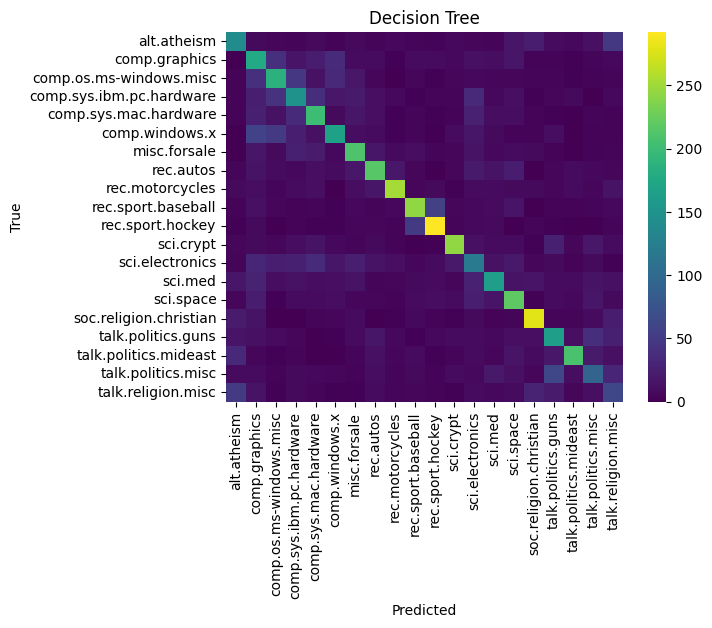

In [57]:
metrics_before_reduction["Decision Tree"] = evaluate(test_df["Category"], clf.predict(test_tfidf_values), news_train.target_names, "Decision Tree")

### Decision Tree Using Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

max_depth = [int(x) for x in np.linspace(100, 1000, 10)]
min_samples_split = [20, 50, 100]
min_samples_leaf = [10, 20, 40]
criterion = ["gini", "entropy", "log_loss"]

random_grid = {
    "max_depth" : max_depth,
    "min_samples_split" : min_samples_split,
    "min_samples_leaf" : min_samples_leaf,
    "criterion" : criterion
}

clf = RandomizedSearchCV(
    estimator=clf,
    param_distributions=random_grid,
    n_iter=50,
    cv=5,
    random_state=42
)

clf.fit(tfidf_features, train_df["Category"]) # really long runtime
clf.best_estimator_

#### Performance Metrics

In [ ]:
metrics_before_reduction["Tuned Decision Tree"] = evaluate(test_df["Category"], clf.predict(test_tfidf_values), news_train.target_names, "Tuned Decision Tree")

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(tfidf_features, train_df["Category"])
clf.get_params()

#### Performance Metrics

In [ ]:
metrics_before_reduction["Random Forest"] = evaluate(test_df["Category"], clf.predict(test_tfidf_values), news_train.target_names, "Random Forest")

### Support Vector Machine

In [ ]:
from sklearn import svm

clf = svm.SVC(random_state=42)
clf.fit(tfidf_features, train_df["Category"])

#### Performance Metrics

In [ ]:
metrics_before_reduction["SVM"] = evaluate(test_df["Category"], clf.predict(test_tfidf_values), news_train.target_names, "SVM")

## After Feature Reduction

In [ ]:
metrics_after_reduction = pd.DataFrame()
metrics_after_reduction.index = ["Accuracy", "Precision", "Recall", "F1 score"]

### Multinomial Logistic Regression Using Gradient Descent

#### Alpha: 0.001, Regularization: L1

In [ ]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(
    loss="log_loss",
    penalty="l1",
    alpha=0.001,
    learning_rate="optimal",
    random_state=42
).fit(svd_features, train_df["Category"])

##### Performance Metrics

In [ ]:
metrics_after_reduction["Log Reg, Alpha=0.001, L1"] = evaluate(test_df["Category"], clf.predict(test_svd_feature_values), news_train.target_names, "Log Reg, Alpha=0.001, L1")

#### Alpha 0.001, Regularization: L2

In [ ]:
clf = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=0.001,
    learning_rate="optimal",
    random_state=42
).fit(svd_features, train_df["Category"])

##### Performance Metrics

In [ ]:
metrics_after_reduction["Log Reg, Alpha=0.001, L2"] = evaluate(test_df["Category"], clf.predict(test_svd_feature_values), news_train.target_names, "Log Reg, Alpha=0.001, L2")

#### Alpha: 0.1, Regularization: L1

In [ ]:
clf = SGDClassifier(
    loss="log_loss",
    penalty="l1",
    alpha=0.1,
    learning_rate="optimal",
    random_state=42
).fit(svd_features, train_df["Category"])

##### Performance Metrics

In [ ]:
metrics_after_reduction["Log Reg, Alpha=0.1, L1"] = evaluate(test_df["Category"], clf.predict(test_svd_feature_values), news_train.target_names, "Log Reg, Alpha=0.1, L1")

#### Alpha: 0.1, Regularization: L2

In [ ]:
clf = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=0.1,
    learning_rate="optimal",
    random_state=42
).fit(svd_features, train_df["Category"])

In [ ]:
metrics_after_reduction["Log Reg, Alpha=0.1, L2"] = evaluate(test_df["Category"], clf.predict(test_svd_feature_values), news_train.target_names, "Log Reg, Alpha=0.1, L2")

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(svd_features, train_df["Category"])
clf.get_depth()

#### Performance Metrics

In [ ]:
metrics_after_reduction["Decision Tree"] = evaluate(test_df["Category"], clf.predict(test_svd_feature_values), news_train.target_names, "Decision Tree")

### Decision Tree Using Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

max_depth = [int(x) for x in np.linspace(100, 1000, 10)]
min_samples_split = [20, 50, 100]
min_samples_leaf = [10, 20, 40]
criterion = ["gini", "entropy", "log_loss"]

random_grid = {
    "max_depth" : max_depth,
    "min_samples_split" : min_samples_split,
    "min_samples_leaf" : min_samples_leaf,
    "criterion" : criterion
}

clf = RandomizedSearchCV(
    estimator=clf,
    param_distributions=random_grid,
    n_iter=50,
    cv=5,
    random_state=42
)

clf.fit(svd_features, train_df["Category"]) # really long runtime
clf.best_estimator_

#### Performance Metrics

In [ ]:
metrics_after_reduction["Tuned Decision Tree"] = evaluate(test_df["Category"], clf.predict(test_svd_feature_values), news_train.target_names, "Tuned Decision Tree")

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(svd_features, train_df["Category"])
clf.get_params()

#### Performance Metrics

In [ ]:
metrics_after_reduction["Random Forest"] = evaluate(test_df["Category"], clf.predict(test_svd_feature_values), news_train.target_names, "Random Forest")

### Support Vector Machine (SVM)

In [ ]:
from sklearn import svm

clf = svm.SVC(random_state=42)
clf.fit(svd_features, train_df["Category"])

#### Performance Metrics

In [ ]:
metrics_after_reduction["SVM"] = evaluate(test_df["Category"], clf.predict(test_svd_feature_values), news_train.target_names, "SVM")

### SVM for 3000 Features

In [ ]:
clf = svm.SVC(random_state=42)
clf.fit(svd3000_features, train_df["Category"]) # really long runtime

#### Performance Metrics

In [ ]:
metrics_after_reduction["SVM, 3000 Features"] = evaluate(test_df["Category"], clf.predict(test_svd3000_feature_values), news_train.target_names, "SVM, 3000 Features")

## Model Comparison

In [ ]:
metrics_before_reduction

In [ ]:
metrics_after_reduction

# Analysis of Results

Although I calculated precision, recall, and F1 score, the purpose of these models was to correctly classify news texts into 20 different categories. Because I was not focused on one particular category, precision and recall were less important than accuracy. Furthermore, as F1 score is a sort of combination of precision and recall, the same logic applies. Therefore, I focused on accuracy in my analyses.

First, I discovered that performing feature reduction really didn't do much to improve my model accuracies. It did improve the metrics of my first logistic regression model, my third logistic regression model, my decision tree, and my tuned decision tree. However, my metrics showed a decrease in the effectiveness of the following models after truncated SVD: my second logistic regression model, my fourth logistic regression model, my random forest, and my SVM. The SVM model that I created using 3000 components did not even yield better results than the SVM model without feature reduction. I only discuss the results of my models after feature reduction below.

Both logistic regression models with a learning rate of 0.001 performed okay, regardless of whether the regularization technique used was L1 or L2 (accuracies of 0.56 and 0.65 respectively). Perhaps a smaller learning rate would yield better results. Based on the confusion matrices, the model does not seem to consistently misclassify one specific category as another. The misclassifications are distributed throughout the categories.

On the flip side, both logistic regression models with a learning rate of 0.1 performed very poorly, regardless of whether the regularization technique used was L1 or L2 (accuracies of 0.05 and 0.20 respectively). In both cases, using L2 regularization yielded slightly better results than L1. For some reason, the regression models with an alpha of 0.1 classified most of the posts as belonging to the category soc.religion.christian. Again, this is probably due to the learning rate being too large. Most likely, the model is underfitting the data.

The decision tree model performed worse than the alpha=0.001 logistic regression models, but better than the alpha=0.1 logistic regression models (accuracy of 0.51). Interestingly, the depth of the decision tree turned out to be 34, which I feel is quite small when working with 100 features.

However, the decision tree model with tuned hyperparameters did perform slightly better (accuracy of 0.53). The maximum depth that was found to lead to the best estimator was 700, which is again odd, especially in comparison to the depth of 34 that the non-tuned decision tree went to. While 34 seemed quite shallow to me, 700 seems far too deep. Regardless, hyperparameter tuning does seem to improve model performance, but the computational cost is quite high. This model took the longest to train using the dataset projected to 100 features.

The random forest model performed even better than both decision tree models (accuracy of 0.69). This may be a result of the fact that random forest uses ensemble learning. Additionally, training this model did not require a significant amount of computational time, which makes this an attractive improvement to a model in this scenario.

SVM yielded the best results in accuracy, precision, recall, and F1 score (0.73, 0.72, 0.72, and 0.72 respectively). Therefore, out of the models tested and analyzed here, this is the best one to use in classifying text into the 20 categories used in the 20 newsgroups text dataset. SVM is known to be effective in high-dimensional spaces, including those in which the number of features is larger than the number of samples (as is the case with the data we are working with). Therefore, it makes sense that this would be a strong contender, if not the strongest model developed.

Because SVM performed the best when trained on the dataset that was reduced to only 100 features, this is the model that I chose to train using the dataset that was reduced to 3000 features instead. The results did somewhat improve accuracy, precision, recall, and F1 score (0.76, 0.78, 0.75, 0.76 respectively). This does suggest that accounting for more variance when performing feature reduction can improve model performance, however, I am not sure if the improvement here is worth the computational time that it takes to fit the SVM model to 3000 features.

Given that the models seemed to be improved by: 1) not reducing features, 2) tuning hyperparameters, and 3) using ensemble learning, an even better model may be gained by applying (or not applying) these methods to SVM. However, method 2 requires significant computational time. Therefore, a data scientist would need to weigh what was more important: higher accuracy or lower computational time. In my case, for this class, I am happy enough with an accuracy of 0.76.